In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import esm
from typing import List, Tuple
import itertools


In [ ]:
#  Load the ESM-MSA model
model, alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
model = model.eval()
batch_converter = alphabet.get_batch_converter()

# Function to perform mutation scan
def mutation_scan(msa: List[Tuple[str, str]], 
                  model = model,
                 target_seq_idx: int = 0,
                 device: str = "cuda") -> np.ndarray:
    """
    Perform mutation scan on a multiple sequence alignment.
    
    Args:
        msa: List of tuples (sequence_name, sequence)
        target_seq_idx: Index of the target sequence in the MSA
        device: Device to run the model on ('cpu' or 'cuda')
    
    Returns:
        mutation_scores: numpy array of shape (L, 20) containing scores for each possible mutation
    """
    model.to(device)
    
    # Prepare MSA data
    msa_batch_labels, msa_batch_strs, msa_batch_tokens = batch_converter([msa])
    msa_batch_tokens = msa_batch_tokens.to(device)
    
    # Target sequence from MSA
    target_seq = msa[target_seq_idx][1]
    L = len(target_seq)
    
    # Get model output
    with torch.no_grad():
        results = model(msa_batch_tokens, repr_layers=[12])
    
    token_representations = results["representations"][12][0]  # (num_seqs, L, hidden_dim)
    
    # Extract embeddings for the target sequence
    target_tokens = token_representations[target_seq_idx, 1:L+1]  # Remove cls and eos tokens
    
    # Calculate mutation scores for all positions and all amino acids
    all_scores = torch.zeros((L, 20), device=device)
    
    # Compute logits for each position
    logits = model.lm_head(target_tokens)  # (L, vocab_size)
    print("Logits shape:", logits.shape)
    
    # Extract scores for amino acids only (skip special tokens)
    aa_logits = logits[:, 4:24]  # 20 amino acids
    
    # Convert to numpy array
    mutation_scores = aa_logits.cpu().detach().numpy()
    
    return mutation_scores

# Function to visualize mutation scan
def plot_mutation_scan(mutation_scores: np.ndarray, 
                       sequence: str,
                       cmap: str = "RdBu_r",
                       vmin: float = None,
                       vmax: float = None) -> None:
    """
    Visualize mutation scan results.
    
    Args:
        mutation_scores: numpy array of shape (L, 20) containing scores for each mutation
        sequence: Original protein sequence
        cmap: Colormap for visualization
        vmin, vmax: Min and max values for colormap scaling
    """
    amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
    
    if vmin is None:
        vmin = np.percentile(mutation_scores, 5)
    if vmax is None:
        vmax = np.percentile(mutation_scores, 95)
    
    plt.figure(figsize=(20, 8))
    plt.imshow(mutation_scores.T, cmap=cmap, aspect="auto", vmin=vmin, vmax=vmax)
    
    # Add labels
    plt.yticks(np.arange(20), amino_acids)
    plt.xlabel("Position")
    plt.ylabel("Mutation")
    
    # Add tick marks for each position
    plt.xticks(np.arange(len(sequence)), 
              [f"{i+1}:{aa}" for i, aa in enumerate(sequence)])
    plt.xticks(rotation=90)
    
    plt.colorbar(label="Mutation score")
    plt.title("Mutation scan using ESM-MSA model")
    plt.tight_layout()
    plt.savefig("mutation_scan.png", dpi=300)
    plt.show()

# Example usage
# Note: You would replace this with your actual MSA data
# In this example:
# - We define a simple MSA with 3 sequences
# - The first sequence is our target protein
example_msa = [
    ("target_protein", "MKFLVLLFNILCLFPILASAGTETEAQQCLTDAGINCTYETALLAAAKTDGSKLPGEYFIVTAGPCMGGLPDFPEGGVFIGTFVTGGCLTAYFSFIGSWVVPLLNPATYSK"),
    ("homolog1", "MKFLVFLFNILCLFPILASAGTDTEAQQCLTDAGINCSYETALLAAAKTDGSKLPGEYFIVTAGPCMGGLPDFPEGGVFIGTFVTGGCLTAYFSFIGSWVVPLLNPATYSK"),
    ("homolog2", "MKFLVLLFNILCLFPPLASAGTETQAQQCLTDAGINCTYEIALLSAAKTDGSKLPGEYFIVTAGPCMGGLPDFPEGGVFIGTFVTGGCLTAYFTFIGSWVVPLLNPTTYSK")
]

# Generate mutation scores
scores = mutation_scan(example_msa, model, target_seq_idx=0)



Logits shape: torch.Size([111, 33])


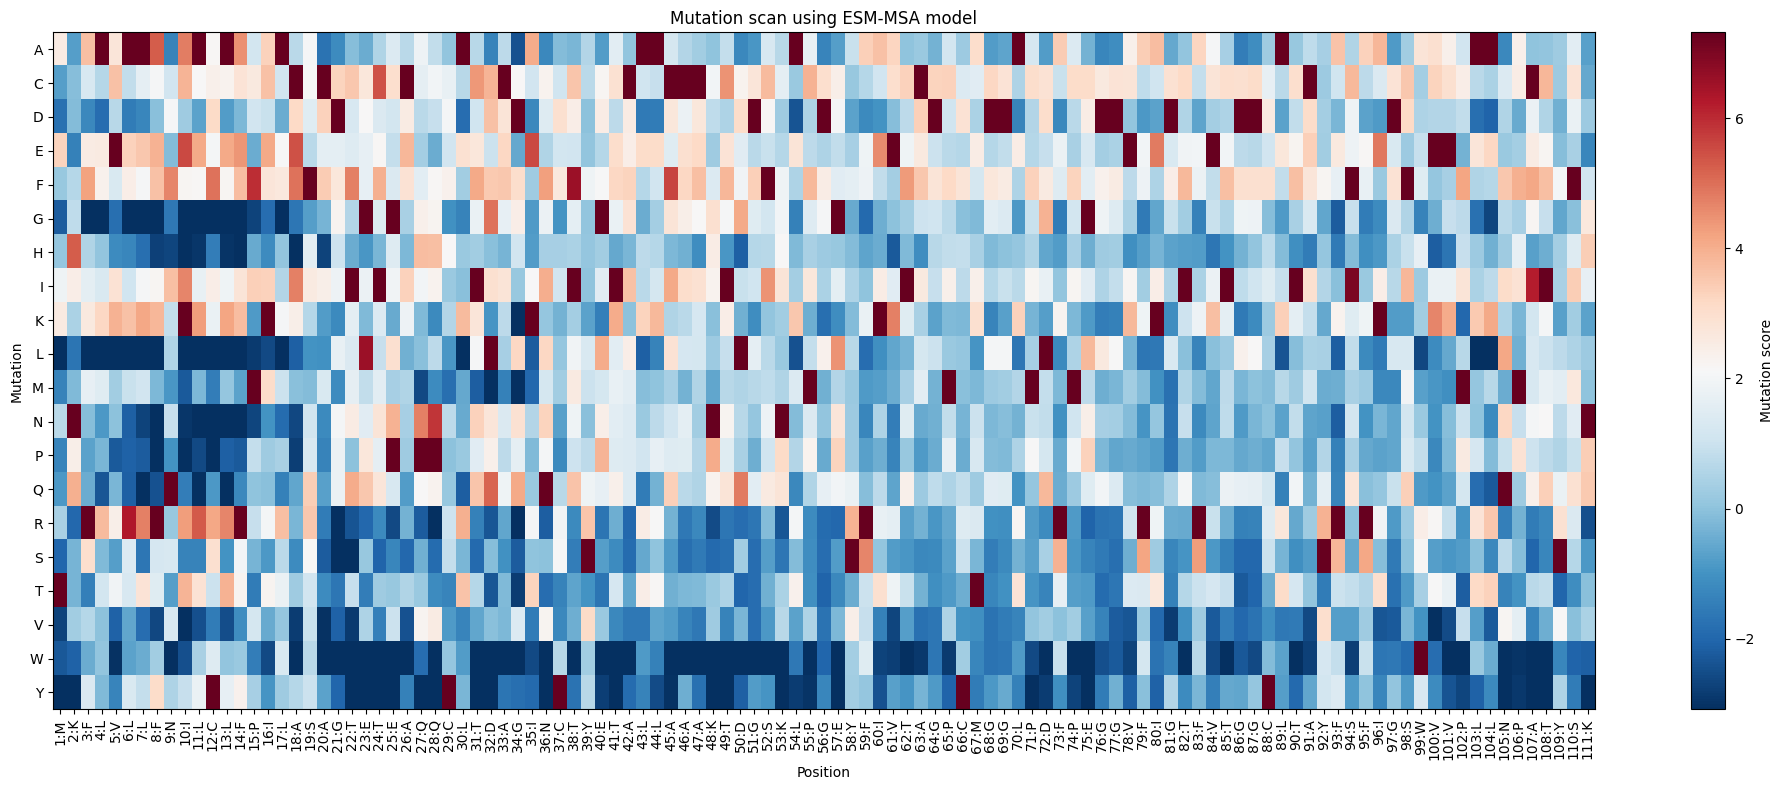

In [18]:
# Visualize results
plot_mutation_scan(scores, example_msa[0][1])



In [ ]:
# Identify top beneficial mutations (higher scores)
def get_top_mutations(scores: np.ndarray, sequence: str, top_n: int = 10) -> List[str]:
    """
    Identify top beneficial mutations based on scores.
    
    Args:
        scores: numpy array of shape (L, 20) containing scores for each mutation
        sequence: Original protein sequence
        top_n: Number of top mutations to return
    
    Returns:
        List of mutations in the format "OriginalAA{Position}NewAA"
    """
    amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
    
    # Get all mutations and their scores
    mutations = []
    for pos in range(len(sequence)):
        orig_aa = sequence[pos]
        orig_aa_idx = amino_acids.index(orig_aa) if orig_aa in amino_acids else -1
        
        for aa_idx, new_aa in enumerate(amino_acids):
            if new_aa != orig_aa:
                mutation = f"{orig_aa}{pos+1}{new_aa}"
                score = scores[pos, aa_idx]
                mutations.append((mutation, score))
    
    # Sort by score (higher is better)
    sorted_mutations = sorted(mutations, key=lambda x: x[1], reverse=True)
    
    # Return top N mutations
    return [(mut, score) for mut, score in sorted_mutations[:top_n]]

# Print top beneficial mutations
top_mutations = get_top_mutations(scores, example_msa[0][1])
print("Top beneficial mutations:")
for mutation, score in top_mutations:
    print(f"{mutation}: {score:.4f}")

In [ ]:
msa_model, alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()

# The decoder function is typically the lm_head or prediction head
# In ESM-MSA, this is the lm_head attribute
lm_head = msa_model.lm_head

# You can inspect the shape and structure of the lm_head
print("LM head type:", type(lm_head))
print("LM head structure:", lm_head)



LM head type: <class 'esm.modules.RobertaLMHead'>
LM head structure: RobertaLMHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)


In [20]:
print(msa_model.lm_head.layer_norm)

(768,)


In [ ]:
# Inspect the details of the LayerNorm module
print(f"LayerNorm details: {module}")
print(f"Normalized shape: {module.normalized_shape}")
print(f"Epsilon value: {module.eps}")
print(f"Elementwise affine: {module.elementwise_affine}")

In [11]:
# For example, you can see the input and output dimensions
if isinstance(lm_head, nn.modules.linear.Linear):
    print("Input dimension:", lm_head.in_features)
    print("Output dimension:", lm_head.out_features)

In [ ]:
# Assuming `output` is the raw output logits from the model
probabilities = torch.softmax(output, dim=-1)
probabilities = torch.softmax(msa_model(output), dim=-1)

In [12]:
for name, module in msa_model.named_modules():
    if isinstance(module, nn.modules.linear.Linear):
        print(f"Found output projection: {name}, shape: {module.in_features} → {module.out_features}")


Found output projection: layers.0.row_self_attention.layer.k_proj, shape: 768 → 768
Found output projection: layers.0.row_self_attention.layer.v_proj, shape: 768 → 768
Found output projection: layers.0.row_self_attention.layer.q_proj, shape: 768 → 768
Found output projection: layers.0.row_self_attention.layer.out_proj, shape: 768 → 768
Found output projection: layers.0.column_self_attention.layer.k_proj, shape: 768 → 768
Found output projection: layers.0.column_self_attention.layer.v_proj, shape: 768 → 768
Found output projection: layers.0.column_self_attention.layer.q_proj, shape: 768 → 768
Found output projection: layers.0.column_self_attention.layer.out_proj, shape: 768 → 768
Found output projection: layers.0.feed_forward_layer.layer.fc1, shape: 768 → 3072
Found output projection: layers.0.feed_forward_layer.layer.fc2, shape: 3072 → 768
Found output projection: layers.1.row_self_attention.layer.k_proj, shape: 768 → 768
Found output projection: layers.1.row_self_attention.layer.v_pro

In [7]:
for name, module in msa_model.named_modules():
    print(f"Module: {name}, Type: {type(module)}")

Module: , Type: <class 'esm.model.msa_transformer.MSATransformer'>
Module: embed_tokens, Type: <class 'torch.nn.modules.sparse.Embedding'>
Module: dropout_module, Type: <class 'torch.nn.modules.dropout.Dropout'>
Module: layers, Type: <class 'torch.nn.modules.container.ModuleList'>
Module: layers.0, Type: <class 'esm.modules.AxialTransformerLayer'>
Module: layers.0.row_self_attention, Type: <class 'esm.modules.NormalizedResidualBlock'>
Module: layers.0.row_self_attention.layer, Type: <class 'esm.axial_attention.RowSelfAttention'>
Module: layers.0.row_self_attention.layer.k_proj, Type: <class 'torch.nn.modules.linear.Linear'>
Module: layers.0.row_self_attention.layer.v_proj, Type: <class 'torch.nn.modules.linear.Linear'>
Module: layers.0.row_self_attention.layer.q_proj, Type: <class 'torch.nn.modules.linear.Linear'>
Module: layers.0.row_self_attention.layer.out_proj, Type: <class 'torch.nn.modules.linear.Linear'>
Module: layers.0.row_self_attention.layer.dropout_module, Type: <class 'tor

In [3]:
lm_head.dense

AttributeError: 'RobertaLMHead' object has no attribute 'in_features'

In [21]:
# Create a simple MSA
msa_sequences = [
    "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG",
    "MKTIRQERLKSIVRILERAKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNVIATPRGYVLAGG",
    "MKPVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVLVQDIAYLRSLGYNIVATPRGYVLAGG"
]

# Convert to batch
batch_converter = alphabet.get_batch_converter()
batch_labels, batch_strs, batch_tokens = batch_converter([(0, msa_sequences)])

# Run the model
with torch.no_grad():
    results = msa_model(batch_tokens)

# Inspect the structure
print("Results dictionary keys:", list(results.keys()))

TypeError: 'int' object is not subscriptable